# [INFO-H515 - Big Data Scalable Analytics](http://uv.ulb.ac.be/course/view.php?id=74317?username=guest)


## TP 2 - Linear Regression with Map Reduce

#### *Yann-Aël Le Borgne, Jacopo De Stefani and Gianluca Bontempi*

####  25/04/2018

This class aims at implementing from scratch map-reduce solutions to linear regression problems. Linear regression consists in approximating an output (response) variable $y$ by a linear combination of a set of inputs (dependent variables) $x_i$.

![](./img/ExampleLinReg.png)

The two main approaches to solve linear regression problems are the Ordinary Least Squares (OLS), and the Gradient Descent (GD). 

### Class objectives:

* Review the solving of a linear regression problem using the standard ML sklearn Python toolbox
* Review the ordinary least square (OLS) solution. Implement it from scratch using numpy
* Implement the Map/Reduce OLS solution using Spark
* Review the Gradient Descent (GD) solution. Implement it from scratch using numpy
* Implement the Map/Reduce GD solution using Spark
* Solve the problem using Spark ML library - LinearRegression, and its OLS and gradient descent implementations
* Interpret Spark optimisation plan and algorithm distribution in the Spark user interface



# Linear regression - Background theory

* Linear regression is a widely used method in predictive analytics.
* It consists in approximating an output by a weighted sum of the inputs, in such a way that the mean square error between the predicted and true outputs is minimized.

### Notations
* Let $(x_i,y_i)$, $1 \le i \le N$, be a set of $N$ observations, with $x_i \in \mathbb{R}^n$ and $y_i \in \mathbb{R}$. $x_i$ are the inputs, and $y_i$ the outputs.
* Let $X$ be the matrix of inputs with rows $x_i$, of size $N \times n$ ($N$ observations, (rows) and $n$ features (columns)). 
* Let $Y \in \mathbb{R}^N$ be the vector of outputs $y_i$.
* Let $\theta \in \mathbb{R}^n$ be the parameters of a linear model $\hat{y_i}=\theta x_i^T$.
* Let $L(y_i, \hat{y}_i)=\frac{1}{2}(y_i-\hat{y}_i)^2$ be the mean squared loss function.




### Solutions to the regression problems

#### Ordinary least squares

[It can be shown](https://theclevermachine.wordpress.com/2012/09/01/derivation-of-ols-normal-equations/) that the set of parameters $\hat{\theta}$ which minimize the loss function $L$ over the whole set of observations $(X,Y)$ is given by

$$
\hat{\theta}^T = (X^T X)^{-1} (X^T Y)
$$

This is the **Ordinary Least Square** solution, which is the closed form solution.

#### Gradient descent 

The closed form solution (OLS) requires a matrix inversion, which is not possible if $X^T X$ is singular (which happens if $n>N$ or if a feature is a linear combination of others). An alternative to the OLS method is the  Gradient Descent (GD) method. The linear regression weights are first drawn at random. They are then iteratively updated by summing and averaging the gradients for all $x_i$ in $X$.    

``` 
GD(X,Y,T,η)
N<-nrow(X)
theta_0 <- random initialization
for t = 1 to T do
    sum_gradient=0
    for i = 1 to N
        sum_gradient=sum_gradient − ηL'(x_i,y_i)
    end_for
    theta_t ← theta_(t−1)+sum_gradient/N
end_for
return theta_t
``` 
L' is the derivative of L. For the squared loss, we have $L'(y_i, \hat{y}_i)=(x_i \theta^T-y_i)x_i$.

Note that the GD approach requires two hyperparameters: The number of iteration $T$, and the learning rate $η$, which controls how 'fast' the linear weights are updated. Tuning $T$ and $η$ to efficiently solve the problem is in practice often difficult. 

### Map/Reduce

If X and Y do not fit in memory, Map/Reduce can be used to solve the linear regression problem in a distributed way. Two cases can be distinguished:

* ** $N$ large and $n$ 'small' ** : $X^TX$ and $X^TY$ are of size $n \times n$ and $n \times 1$, respectively, and can be assumed to be 'small' enough to fit in the memory of a single machine. Only the matrix products $X^TX$ and $X^TY$ are computed with Map/Reduce in a distributed way. The matrix inversion $(X^TX)^{-1}$ and resulting product $\hat{\theta}^T = (X^T X)^{-1} (X^T Y)$ are then computed on a single machine.

* ** $n$ 'large' ** : The matrix product $X^TX$ has size $n^2$ which can become too large to fit on a single machine. The risk that $X^TX$ is singular and that the inverse cannot be computed is also increased. The Map/Reduce GD method must be used.



# General imports

In [2]:
import time
import os 
import numpy as np

%matplotlib notebook  
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


We will be using mostly numpy and Spark RDD libraries. For reference, you can look up the details of the relevant Spark methods in [Spark's Python API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) and the relevant [NumPy](https://docs.scipy.org/doc/numpy/reference/index.html) methods in the NumPy Reference.

# 1) Dataset generation

Let us first generate an artificial dataset of $N$ observations where the output $y$ is a linear combination of $n$ inputs plus gaussian noise.

In [3]:
def genData(N,n,random_seed):
    
    start = time.time()

    np.random.seed(0)   

    #Inputs and the weights of the linear combination are drawn at random
    X=np.random.rand(N,n)
    theta=np.random.rand(n)
    #noise=np.random.rand(N)

    Y=np.dot(X,theta)#+noise
    Y=Y[:,np.newaxis]
    Z=np.concatenate((X,Y),axis=1)

    print("Number of observations :",N)
    print("Number of features :",n)

    print("Dimension of X :",X.shape)
    print("Dimension of theta :",theta.shape)
    print("Dimension of Y :",Y.shape)

    end = time.time()
    print("Time to create artificial data: ",round(end - start,2),"seconds")
    
    return (X,Y,Z,theta)

In [4]:
#Let us generate the dataset
N=100
n=2
(X,Y,Z,theta)=genData(N,n,0)

Number of observations : 100
Number of features : 2
Dimension of X : (100, 2)
Dimension of theta : (2,)
Dimension of Y : (100, 1)
Time to create artificial data:  0.17 seconds


<IPython.core.display.Javascript object>


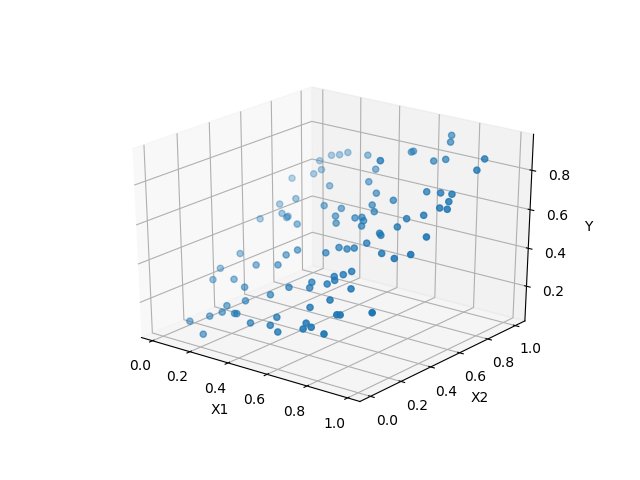

In [5]:
#Warning: Do not plot if N>1000 !
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[0:N,0],X[0:N,1],Y[0:N])
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')


In [6]:
#Check theta values
theta

array([ 0.31179588,  0.69634349])

# 2) Ordinary Least Squares

Let us first solve the linear regression using standard approaches:

* Using Python sklearn and the sklearn.linear_model function
* Using the least mean square equation with numpy

## 2.1) Centralised approach

### 2.1.1) Parameter identification using sklearn

Let us compute the model coefficients with the [sklearn.linear_model](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) function

In [7]:
from sklearn import linear_model

start = time.time()

model = linear_model.LinearRegression(fit_intercept=False)
model.fit(X,Y)

end = time.time()

print("Regression coefficient found with sklearn:",model.coef_)
print("Time to fit linear model with sklearn: ",round(end - start,4),"seconds")


Regression coefficient found with sklearn: [[ 0.31179588  0.69634349]]
Time to fit linear model with sklearn:  0.016 seconds


In [8]:
theta

array([ 0.31179588,  0.69634349])

### 2.1.2) Parameter identification using numpy

Let us compute the model coefficients using the OLS solution, with numpy [`dot`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html), [`transpose`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.transpose.html), and [`linalg.inv`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.inv.html) functions.   

**Exercise:**

* Compute $X^TX$ using the numpy `dot` function, and store result in a variable XtX
* Compute $X^TY$ using the numpy `dot` function, and store result in a variable XtY
* Compute the inverse of $X^TX$ using the numpy `linalg.inv` function, and store result in a variable XtX_inverse
* Compute coefficient $\hat{\theta}=(X^T X)^{-1} (X^T Y)$ using the numpy `dot` function and store the result in a variable theta_hat
* Check that theta_hat is the same as the result found with `sklearn.linear_model`

In [9]:
start = time.time()

XtX=np.dot(np.transpose(X),X)
XtY=np.dot(np.transpose(X),Y)

XtX_inverse=np.linalg.inv(XtX)

theta_hat=np.dot(XtX_inverse,XtY)

end = time.time()

print("Size of X^T X :",XtX.shape)
print("Size of X^T Y :",XtY.shape)
print("Size of (X^T X)^-1 :",XtX_inverse.shape)
print("Size of \hat{theta} :",theta_hat.shape)

print("Regression coefficient found with numpy native implementation:",theta_hat)
print("Time to fit linear model with numpy: ",round(end - start,4),"seconds")


Size of X^T X : (2, 2)
Size of X^T Y : (2, 1)
Size of (X^T X)^-1 : (2, 2)
Size of \hat{theta} : (2, 1)
Regression coefficient found with numpy native implementation: [[ 0.31179588]
 [ 0.69634349]]
Time to fit linear model with numpy:  0.0031 seconds


## 2.2) Map/Reduce approach for OLS

Summary of the approach:

* $X^T X$ and $X^T Y$ are computed in a distributed way.
* $X^T X$ and $X^T Y$ have size $n \times n$ and $n$, with $n$ small. $(X^T X)^{-1} (X^T Y)$ can be computed locally (no need to distribute the computation of the matrix inverse).

#### Distribution of the computation of $X^T X$ and $X^T Y$

* Let $Z=[X|Y]$ be the $X$ matrix augmented with $Y$ as the last column.
* Let $Z$ be partitioned into $B$ row blocks $Z_k$ of size $N_B \times (n+1)$

$$Z = \left[\begin{array}
{r}
Z_1  \\
Z_2  \\
...\\
Z_B
\end{array}\right]
$$


**The distributed implementation will consist in computing $X^TX$ and $X^TY$ in parallel using the block $Z_k$**.

* **Stage 1**: Partitioning. Partition $Z$ in $B$ blocks $Z_k$, $1 \le k \le B$. This can be done when calling the `parallelize` function to create the Spark Resilient Distributed Dataset (RDDs). 
* **Stage 2**: Computation of partial $X^TX$ with mapping. For each row of the partition $Z_k$, return xtx$= x_k^T x_k$ (size $n \times n$).
* **Stage 3**: Reduce. Sum all xtx.
* **Stage 4**: Computation of partial $X^TY$ with mapping. For each row of the partition $Z_k$, return xty$= x_k^T y_k$ (size $n \times 1$).
* **Stage 5**: Reduce. Sum all xty.
* **Stage 6**: Collect. Collect the reduced XtX and XtY, and compute $\hat{\theta}^T = (X^T X)^{-1} (X^T Y)$.



### Start Spark session

In [10]:
os.environ['PYSPARK_SUBMIT_ARGS'] ="--conf spark.driver.memory=2g  pyspark-shell"

from pyspark.sql import SparkSession

#Start Spark session with local master and 2 cores
spark = SparkSession \
    .builder \
    .master("local[2]") \
    .appName("LinearRegression") \
    .getOrCreate()

#When dealing with RDDs, we work the sparkContext object. See https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.SparkContext
sc=spark.sparkContext

### Create RDD with B partitions

In [13]:
#Let us use 2 partitions
B=2
Z_RDD=sc.parallelize(Z,B).cache()

In [14]:
Z_RDD.count()

100

**Exercise**

* Open the Spark UI (yourIP:4040), check the DAG visualisation and event timeline
* Change the number to B=5 partitions et reparallelize Z. What change do you expect in the event timeline?

### 2.2.1) Approach 1: map function

The standard approach for Map/Reduce consists in applying a map function to each row of an RDD using the `map` operator, and reduce the results using the `reduce` operator. Below is an example of the Map/Reduce implementation for computing XtX.

In [16]:
def xtx_row(z):
    #x is all columns except the last one (y)
    x=z[:-1]
    xtx=np.outer(x,x)
    return xtx

XtX=Z_RDD.map(xtx_row).reduce(lambda x,y:(x+y))


**Exercise:**
    
* What is the shape (number of rows/columns) of the resulting RDD?
* Check the DAG, event timeline, and number of records/partitions in the Spark UI

In [15]:
XtX.shape

(2, 2)

**Exercise:**

* Apply the same approach as xtx_row for computing XtY. Call that function xty_row
* Compute the coefficients $\hat{\theta}=(X^T X)^{-1} (X^T Y)$ using the numpy `dot` and `linalg.inv` functions and store the result in a variable theta_hat
* Check that theta_hat is the same as the result found with `sklearn.linear_model` (no map/reduce needed here) 

In [17]:
def xty_row(z):
    x=z[:-1]
    #y is the last column
    y=z[-1]
    xty=x*y
    return xty

start = time.time()

XtY=Z_RDD.map(xty_row).reduce(lambda x,y:(x+y))

XtX_inverse=np.linalg.inv(XtX)

theta_hat=np.dot(XtX_inverse,XtY)

end = time.time()

print("Size of X^T X :",XtX.shape)
print("Size of X^T Y :",XtY.shape)
print("Size of (X^T X)^-1 :",XtX_inverse.shape)
print("Size of \hat{theta} :",theta_hat.shape)

print("Regression coefficient found with Spark map function:",theta_hat)
print("Time to fit linear model with Spark map function, combined computation of xtx and xty: ",round(end - start,2),"seconds")


Size of X^T X : (2, 2)
Size of X^T Y : (2,)
Size of (X^T X)^-1 : (2, 2)
Size of \hat{theta} : (2,)
Regression coefficient found with Spark map function: [ 0.31179588  0.69634349]
Time to fit linear model with Spark map function, combined computation of xtx and xty:  0.11 seconds


### 2.2.2) Approach 2 : map function with combined computation of xtx and xty

Instead of using to separate map/reduce for computing XtX and XtY, both can be computed in a single map/reduce (since x and y are in z).

**Exercise:**

* Modify the xtx_row function in a xtx_xty_row function so that xtx and xty are computed in a single map. The output should be a tuple (xtx,xty)
* Modify the map/reduce pipeline so the xtx_xty_row is applied, and adapt the reduce part so both elements (xtx,xty) are summed

In [18]:
def xtx_xty_row(z):
    x=np.array(z[:-1])
    y=z[-1]
    xtx=np.outer(x,x)
    xty=np.dot(x,y)
    return (xtx,xty)

In [19]:
start = time.time()

(XtX,XtY)=Z_RDD.cache().map(xtx_xty_row)\
.reduce(lambda xtx_xty0,xtx_xty1:(xtx_xty0[0]+xtx_xty1[0],xtx_xty0[1]+xtx_xty1[1]))

XtX_inverse=np.linalg.inv(XtX)

theta_hat=np.dot(XtX_inverse,XtY)

end = time.time()

print("Size of X^T X :",XtX.shape)
print("Size of X^T Y :",XtY.shape)
print("Size of (X^T X)^-1 :",XtX_inverse.shape)
print("Size of \hat{theta} :",theta_hat.shape)

print("Regression coefficient found with Spark map function, combined computation of xtx and xty:",theta_hat)
print("Time to fit linear model with Spark map function, combined computation of xtx and xty: ",round(end - start,2),"seconds")


Size of X^T X : (2, 2)
Size of X^T Y : (2,)
Size of (X^T X)^-1 : (2, 2)
Size of \hat{theta} : (2,)
Regression coefficient found with Spark map function, combined computation of xtx and xty: [ 0.31179588  0.69634349]
Time to fit linear model with Spark map function, combined computation of xtx and xty:  0.12 seconds


# 3) Gradient Descent



## 3.1) Centralised approach

``` 
GD(X,Y,T,η)
N<-nrow(X)
theta_0 <- random initialization
for t = 1 to T do
    sum_gradient=0
    for i = 1 to N
        sum_gradient=sum_gradient − ηL'(x_i,y_i)
    end_for
    theta_t ← theta_(t−1)+sum_gradient/N 
end_for
return theta_t 
``` 
L' is the derivative of L. For the squared loss, we have $L'(y_i, \hat{y}_i)=(x_i \theta^T-y_i)x_i$.

Below is a function that implements this algorithm.

In [20]:
def GD(Z,T,eta,random_seed=0):
    (N,n)=Z.shape
    n=n-1

    np.random.seed(random_seed)
    theta_hat=np.random.rand(n)

    for t in range(T):
        sum_gradient=0
        for i in range(N):
            sum_gradient=sum_gradient+getGradient(Z[i,:],eta,theta_hat)
        
        theta_hat=theta_hat+sum_gradient/N
    
    return theta_hat

**Exercise:**

Implement a function getGradient, that takes as inputs z, eta and theta_hat, and returns the gradient at z using the derivative $L'(y_i, \hat{y}_i)=(x_i \theta^T-y_i)x_i$ 

In [21]:
def getGradient(z,eta,theta_hat):
    x=z[:-1]
    y=z[-1]
    
    gradient=-eta*(np.dot(x,theta_hat)-y)*x
    
    return gradient

Run with T=50, and eta=1

In [26]:
theta_hat=GD(Z,50,1)

In [27]:
theta_hat

array([ 0.31294729,  0.69513227])

## 3.2) Map/Reduce approach

Notice that getGradient can be applied row-wise to the Z array, and that all gradients can be summed using a reduce action.

**Exercise:**

Write a function GD_MR equivalent to GD, that implements the gradient descent in a map/reduce way. Tip: Start from Z_RDD, map getGradient, reduce by summing the results.

In [28]:
def GD_MR(Z,T,eta,random_seed=0):
    (N,n)=Z.shape
    n=n-1

    np.random.seed(random_seed)
    theta_hat=np.random.rand(n)

    for t in range(T):
        sum_gradient=Z_RDD.map(lambda z: getGradient(z,eta,theta_hat)).reduce(lambda gradient1,gradient2:(gradient1+gradient2))

        theta_hat=theta_hat+sum_gradient/N
    
    return theta_hat


In [29]:
theta_hat=GD_MR(Z,50,1)

In [30]:
theta_hat

array([ 0.31294729,  0.69513227])

Check in the Spark UI the resulting sequences of Spark jobs.

# 4) Linear regression with Spark ML

The documentation for linear regression in Spark ML can be found at https://spark.apache.org/docs/latest/ml-classification-regression.html#linear-regression. 

It implements the OLS and gradient descent algorithms, which can be chosen by means of the `solver` parameter:
* solver='normal' : Ordinary least squares
* solver='l-bgfs': Gradient descent approach, using [the limited memory BGFS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) optimisation algorihm (a more efficient version of the vanilla gradient descent we implement in section 3)
* solver='auto': Default parameter. It lets Spark choose beteen normal and l-bgfs, depending on the number of input variables (normal if chosen if number of features<=4096). 

In order to use the LinearRegression interface, let us first format input data in a dataframe with `label` and `features` columns:


In [31]:
from pyspark.ml.linalg import Vectors

Z_RDD_tmp = map(lambda z: (float(z[-1]), Vectors.dense(z[0:-1])), Z)
Z_DF = spark.createDataFrame(Z_RDD_tmp,schema=["label", "features"])

Z_DF.show(5)

+------------------+--------------------+
|             label|            features|
+------------------+--------------------+
|0.6691352490507825|[0.54881350392732...|
|0.5673649951209327|[0.60276337607164...|
|0.5818579819191105|[0.42365479933890...|
|0.7574182130810158|[0.43758721126269...|
|0.5674730853311307|[0.96366276050102...|
+------------------+--------------------+
only showing top 5 rows



In [32]:
Z_DF.count()

100

We can now fit the model. 

**Exercise:**

* Fit the model with the normal and l-bgfs algorithms. 
* Check the Spark UI and compare the different stages


In [37]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(maxIter=10,solver="l-bfgs")
#lr = LinearRegression(solver="normal")

# Fit the model
lrModel = lr.fit(Z_DF)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)

Coefficients: [0.311795882069,0.696343489005]
Intercept: -1.3057799286286809e-10
numIterations: 5
objectiveHistory: [0.4949999999999998, 0.0015133886737815209, 1.0363354415579748e-05, 5.931637812062361e-11, 3.547904925174226e-20]
RMSE: 0.000000


In [38]:
theta

array([ 0.31179588,  0.69634349])

## Relevant links

* For a more practical application, see https://github.com/spark-mooc/mooc-setup/blob/master/ML_lab3_linear_reg_student.ipynb where regression with Spark ML is used to predict the year of a movie.

Research articles on distributed gradient descent:

* Zinkevich, M., Weimer, M., Li, L., & Smola, A. J. (2010). Parallelized stochastic gradient descent. In Advances in neural information processing systems (pp. 2595-2603). http://martin.zinkevich.org/publications/nips2010.pdf
* Chu, C. T., Kim, S. K., Lin, Y. A., Yu, Y., Bradski, G., Olukotun, K., & Ng, A. Y. (2007). Map-reduce for machine learning on multicore. In Advances in neural information processing systems (pp. 281-288). https://papers.nips.cc/paper/3150-map-reduce-for-machine-learning-on-multicore.pdf

